count    22434.000000
mean        18.329978
std         15.352390
min          0.000000
25%         10.000000
50%         15.000000
75%         25.000000
max        115.000000
Name: TEMPS_TRAJET_MIN, dtype: float64


/opt/mamba/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


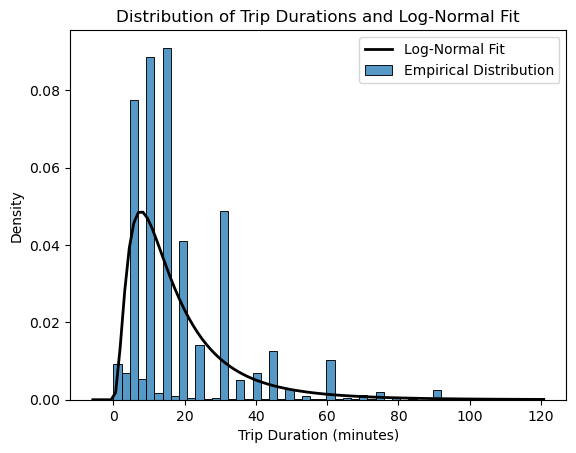

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(filepath):
    """
    Charge les données depuis un fichier CSV et prépare les colonnes nécessaires.
    """
    data = pd.read_csv(filepath, sep=';', encoding='ISO-8859-1', decimal=',')
    return data

def calculate_trip_durations(data):
    """
    Calcule les durées de trajet en minutes, en traitant les cas de passage au jour suivant.
    """
    def convert_to_minutes(start_time_str, end_time_str):
        start_time = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S')
        end_time = datetime.strptime(end_time_str, '%Y-%m-%d %H:%M:%S')
        if end_time < start_time:  # Passage au jour suivant
            end_time = datetime(year=start_time.year, month=start_time.month, day=start_time.day, hour=23, minute=59)
        duration = (end_time - start_time).total_seconds() / 60.0
        return duration

    data['TEMPS_TRAJET_MIN'] = data.apply(lambda row: convert_to_minutes(row['INSTANT_DEPART'], row['INSTANT_ARRIVEE']), axis=1)
    return data

def filter_data(data):
    """
    Filtre les données pour ne garder que les trajets de moins de 120 minutes.
    """
    return data[data['TEMPS_TRAJET_MIN'] < 120]

def descriptive_statistics(data):
    """
    Calcule et affiche les statistiques descriptives des temps de trajet.
    """
    stats = data['TEMPS_TRAJET_MIN'].describe()
    print(stats)

def fit_distributions(data):
    """
    Ajuste les données à différentes distributions et sélectionne la meilleure.
    """
    temps_trajet_clean = data['TEMPS_TRAJET_MIN']
    params = stats.lognorm.fit(temps_trajet_clean)
    D, p_value = stats.kstest(temps_trajet_clean, 'lognorm', args=params)
    return params

def plot_distributions(data, params):
    """
    Affiche la distribution empirique des temps de trajet et la courbe de la loi log-normale ajustée.
    """
    sns.histplot(data['TEMPS_TRAJET_MIN'], bins=50, kde=False, stat='density', label='Empirical Distribution')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.lognorm.pdf(x, params[0], loc=params[1], scale=params[2])
    plt.plot(x, p, 'k', linewidth=2, label='Log-Normal Fit')
    plt.title('Distribution of Trip Durations and Log-Normal Fit')
    plt.xlabel('Trip Duration (minutes)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Main execution
filepath = '/path/to/your/file.csv'  # Update this to your file path
data = load_and_prepare_data('/home/onyxia/Projet_statapp/data/EMP_deplacements_Charme.csv')
data = calculate_trip_durations(data)
data = filter_data(data)
descriptive_statistics(data)
params = fit_distributions(data)
plot_distributions(data, params)
